In [2]:
import scipy.io as sio
import os

dataPath = '../../data'
subjectFiles = os.listdir(dataPath)
subject1Path = os.path.join(dataPath, subjectFiles[0])
subject1Files = os.listdir(subject1Path)
subject1Block1Path = os.path.join(subject1Path, subject1Files[0])

data = sio.loadmat(subject1Block1Path)
data = data['data']
data = {n: data[n][0,0] for n in data.dtype.names}

eeg = data['EEG']
eeg_fs = data['fs']


fmri = data['fMRI']
fmri_tr = data['TR']

eventTimes = data['stimOnsetTime']

In [5]:
data['G'].shape

(11010, 6)

In [88]:
import numpy as np
from scipy.signal import resample

def resample_fmri(data: np.ndarray, target_tr: float = 2, eeg_fs: int = 100) -> np.ndarray:
    """
    Resample fMRI data to a target TR (time resolution).
    
    Args:
        data: np.ndarray - fMRI data to resample
        target_tr: float - target TR in seconds
        
    Returns:
        np.ndarray - resampled fMRI data
    """
    # Get current TR from data
    current_tr = 1 / eeg_fs  # current sampling rate (based on EEG)
    
    # Calculate resampling factor
    resampling_factor = int(target_tr / current_tr)
    
    # Resample data
    resampled_data = resample(data, num=int(data.shape[1] / resampling_factor), axis=1)
    resampled_zeros = np.zeros(data.shape)
    resampled_zeros[:, ::resampling_factor] = resampled_data
    return resampled_zeros

In [129]:
data['modulatory_type'][0]

array([array(['face'], dtype='<U4'), array(['car'], dtype='<U3'),
       array(['house'], dtype='<U5'), array(['high'], dtype='<U4'),
       array(['low'], dtype='<U3')], dtype=object)

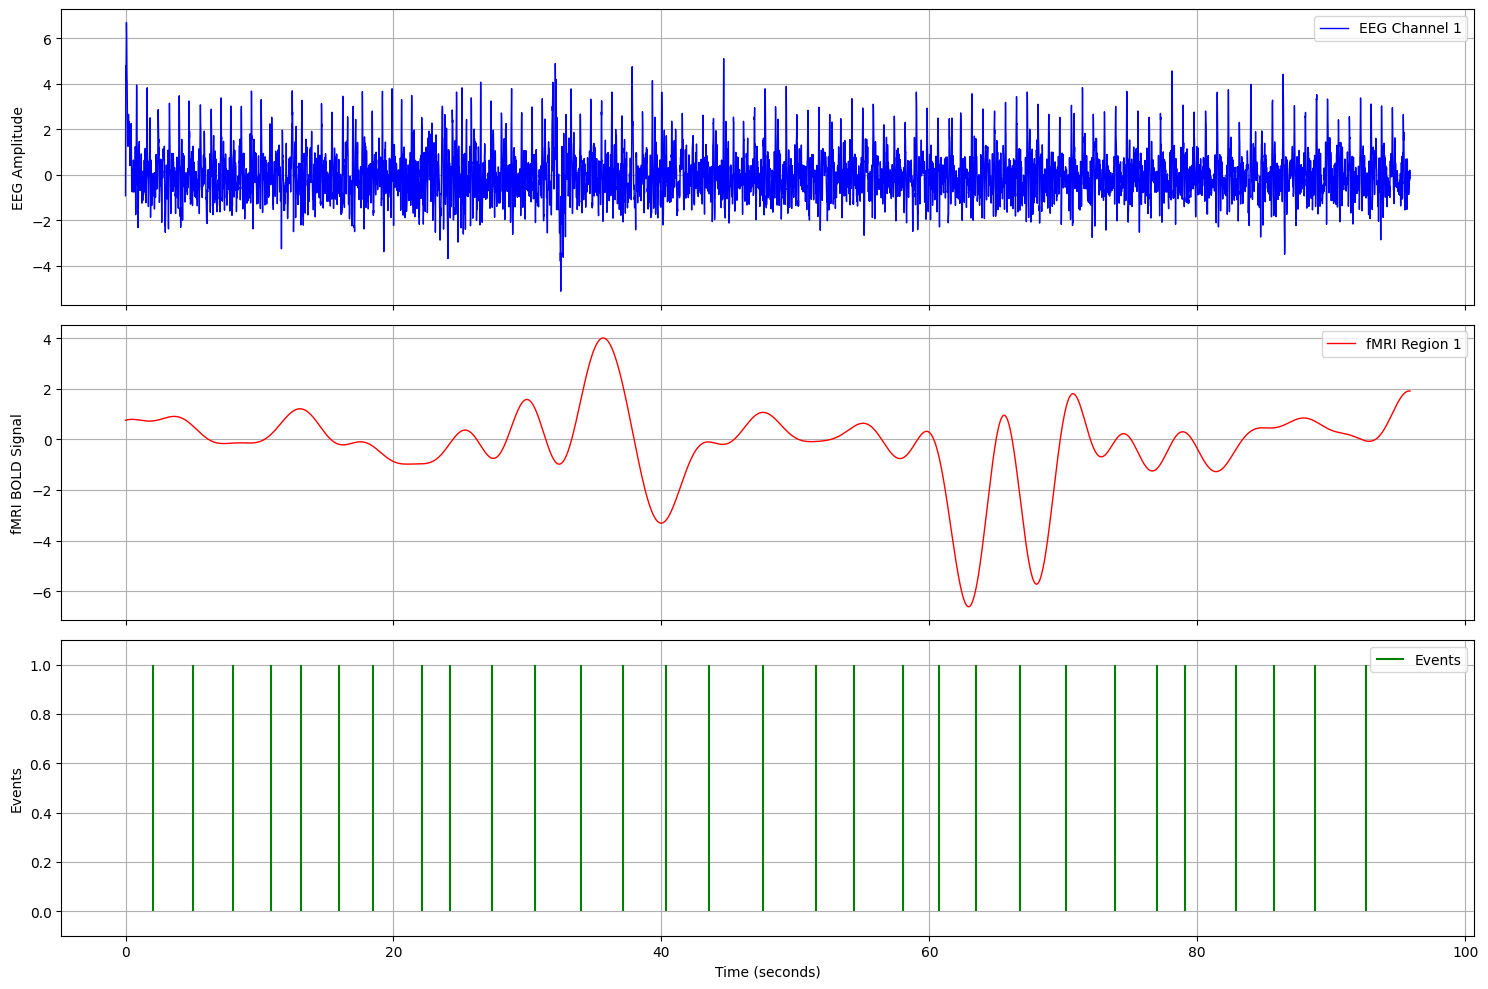

In [131]:
import numpy as np
import matplotlib.pyplot as plt

def plot_eeg_fmri(eeg, fmri, eventTimes, n_events=5):

    # resampled_fmri = resample_fmri(fmri, target_tr=fmri_tr[0,0], eeg_fs=eeg_fs[0,0])

    events = eventTimes[0:n_events].round(2)
    next_event = eventTimes[n_events].round(2)

    # Create time arrays for EEG and fMRI
    eeg_time = np.arange(next_event, step=1/eeg_fs[0,0])
    fmri_time = np.arange(next_event, step=1/eeg_fs[0,0])

    # Create the figure with three subplots sharing x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    # Plot EEG data (first channel)
    ax1.plot(eeg_time, eeg[0,0:int(next_event*100)], 'b-', linewidth=1, label='EEG Channel 1')
    ax1.set_ylabel('EEG Amplitude')
    ax1.legend()
    ax1.grid(True)

    # Plot fMRI data (first voxel)
    ax2.plot(fmri_time, fmri[5,0:int(next_event*100)], 'r-', linewidth=1, label='fMRI Region 1')
    ax2.set_ylabel('fMRI BOLD Signal')
    ax2.legend()
    ax2.grid(True)
# ax2 = ax1.twinx()
# ax2.set_ylabel('fMRI Signal', color='tab:red')
# ax2.scatter(fmri_times, resampled_fmri[0], color='tab:red', alpha=0.6, label='fMRI', marker='o')
# ax2.tick_params(axis='y', labelcolor='tab:red')

    # Plot events as vertical lines
    ax3.vlines(events, 0, 1, color='g', label='Events')
    ax3.set_ylabel('Events')
    ax3.set_ylim(-0.1, 1.1)
    ax3.legend()
    ax3.grid(True)

    # Set common x label
    ax3.set_xlabel('Time (seconds)')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return fig

fig = plot_eeg_fmri(eeg, fmri, eventTimes.flatten(), n_events=30)
plt.show()